## Оценка эффективности торговых точек

## Материалы:
[Презентация](https://yadi.sk/i/HJcGv-BdQWQPow)

Задача: Выявить ключевые метрики оценки эффективности и на их основании оценить эффективность магазинов сети.

В нашем распоряжении данные о покупках в магазине строительных материалов «Строили, строили и наконец построили».

Файл retail_dataset.csv:

- `purchaseId` — id чека;
- `item_ID` — id товара;
- `purchasedate` — дата покупки;
- `Quantity` — количество товара;
- `CustomerID` — id покупателя;
- `ShopID` — id магазина;
- `loyalty_program` — участвует ли покупатель в программе лояльности;

Файл product_codes.csv:

- `productID` — id товара;
- `price_per_one` — стоимость одной единицы товара;

#### Гипотезы:
- Покупатели, участвующие в программе лояльности имеют средний чек выше, чем покупатели без программы лояльности
- Выручка по пользователям, участвующим в программе лояльности выше, чем выручка по пользователям, не участвующим в программе лояльности


### План:
1. [Открыть файл с данными и изучить общую информацию, выявить проблемы в данных](#start)
2. [Предобработка данных:](#preparing_data)
 - [Привести название столбцов к нижнему регистру;](#column_to_lowercase)
 - [Проверить и привести данные к нужным типам при необходимости;](#check_type)
 - [Проверить данные на наличие пропусков, заполнить пропуски при необходимости (customer_id);](#check_empty_values)
 - [Обработать отрицательные значения;](#negative_quantity)
 - [Проверить данные на наличие дубликатов;](#check_duplicate_values)
 - [Добавить столбец с общей стоимостью покупки](#add_total_cost)
 - [Добавить столец с категорией товара](#categoty_purchase)
3. [Провести исследовательский анализ данных:](#research_analysis)
 - [Выяснить данными за какой период мы располагаем. Найти максимальную и минимальную дату.](#check_period) 
 - [Исследовать данные и построить графики для каждого магазина по неделям по трем метрикам:](#metrics_by_week)
     - [выручке;](#graph_revenue)
     - [количеству купленных единиц товара;](#graph_quantity)
     - [количеству возвратов;](#graph_return)
     - [среднему чеку](#graph_avg_check)
 - [Рассчитать средний чек, выручку, процент возвратов, количество проданных товаров по магазину за весь период;](#metrics_by_shop)
4. [Анализ данных по сегментам участия/не участия в программе лояльности:](#loyalty_program_analysis)
 - [Исследовать распределение среднего чека на пользователя;](#avg_check_distribution) 
 - [Рассчитать Retention Rate;](#retention_rate)
 - [Рассчитать LTV](#ltv)
 - [Рассчитать средний чек по 2 группам(участвующие в программе лояльности/нет) по магазинам](#avg_check_loyalty_shop)
4. [Проверить гипотезы:](#check_hypotheses)
 - [средний чек покупателей, участвующих в программе лояльности, и покупателей, не участвующих в программе лояльности, различается](#avg_check_stat)
 - [средняя выручка по покупателям , участвующих в программе лояльности, и покупателям, не участвующих в программе лояльности, различается](#avg_revenue_stat)
5. [Сформулировать и подготовить презентацию по ключевым выводам исследования](#summary)


<a id="start"></a>
### Шаг 1. Открыть файл с данными и изучить общую информацию, выявить проблемы в данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import pylab as pl


In [4]:
product_data = pd.read_csv('/datasets/product_codes.csv')
retail_data = pd.read_csv('/datasets/retail_dataset.csv')
display(product_data.head())
display(retail_data.head())

,productID,price_per_one
0,85123A,2.55
1,71053,3.39
2,84406B,2.75
3,84029G,3.39
4,84029E,3.39


,purchaseid,item_ID,Quantity,purchasedate,CustomerID,ShopID,loyalty_program
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0.0
1,538862,22195,0,2016-12-14 14:11:00,22389.0,Shop 0,1.0
2,538855,21239,7,2016-12-14 13:50:00,22182.0,Shop 0,1.0
3,543543,22271,0,2017-02-09 15:33:00,23522.0,Shop 0,1.0
4,543812,79321,0,2017-02-13 14:40:00,23151.0,Shop 0,1.0


Загруженный датасет product_data состоит 2 столбцов. В первом столбце (productID) находятся уникальные идентификаторы  товаров, идентификатор состоит из числовых и буквенных значений; во втором столбце (price_per_one) указана стоимость одной единицы товара. 

Загруженный датасет retail_data состоит из 7 столбцов. В первом столбце (purchaseid) указан идентификатор чека; во втором столбце (item_ID) находится уникальный идентификатор  товара, этот столбец является ключом по которому мы сможем в дальнейшем при анализе объединить этот датасет с product_data по столбцу item_id. В столбце Quantity указано количество приобретенного товара покупателем; столбец  purchasedate содержит дату и время совершения покупки; в столбце CustomerID - указаны уникальные идентификаторы покупателей, столбец записан в дробном формате; столбец ShopID содержит идентификаторы магазинов и столбец loyalty_program содержит информацию- является ли покупатель участником программы лояльности или нет. Можно заметить, что названия столбцов записаны в верхнем регистре и в разных стилях, далее мы приведем название столбцов в один формат.

<a id="preparing_data"></a>
### Шаг 2. Предобработка данных

<a id="column_to_lowercase"></a>
Приведем название столбцов к единому формату:

In [5]:
#rename
retail_data.columns = ['purchase_id','item_id','quantity','purchase_date','customer_id','shop_id','loyalty_program']
product_data.columns = ['item_id', 'price_per_one']

<a id="check_type"></a>
Проверим типы данных в датасетах:

In [6]:
product_data.info()
print()
retail_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9969 entries, 0 to 9968
Data columns (total 2 columns):
item_id          9969 non-null object
price_per_one    9969 non-null float64
dtypes: float64(1), object(1)
memory usage: 155.9+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
purchase_id        105335 non-null object
item_id            105335 non-null object
quantity           105335 non-null int64
purchase_date      105335 non-null object
customer_id        69125 non-null float64
shop_id            105335 non-null object
loyalty_program    105335 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ MB


Датасет product_data состоит из 2 столбцов и 9969 строк. Столбцу productID присвоен тип данных object, так как мы указывали выше в нем содержатся буквенно-числовые значения. Столбцу  price_per_one присвоен тип данных float64.

Датасет retail_data состоит из 7 столбцов и 105335 строк. Столбец purchasedate имеет тип данных object, но по условию в нем содержится информация о дате и времени совершения покупки, далее приведем столбец к типу даных datetime. Столбцу loyalty_program присвоен тип данных float64, по условию в нем содержится информация является ли покупатель участником программы лояльности или нет, то есть бинарное значение, далее заменим тип данных в столбце на boolean. Можно заметить, что по столбцу CustomerID меньше строк, что свидетельствует о наличие пропусков в данных, далее исследуем данный столбец, чтобы выяснить можем ли мы заменить пропуски в данных.

Заменим типы данных в столбцах purchase_date и loyalty_program:

In [7]:
#change type
retail_data.purchase_date = pd.to_datetime(retail_data.purchase_date)
retail_data.loyalty_program = retail_data.loyalty_program.astype('bool')


Проверим разброс данных методом describe():

In [8]:
#большое отрицательное значение!
retail_data.describe()

,quantity,customer_id
count,105335.000000,69125.000000
mean,7.821218,21019.302047
std,327.946695,1765.444679
min,-74216.000000,18025.000000
25%,0.000000,19544.000000
50%,2.000000,20990.000000
75%,7.000000,22659.000000
max,74214.000000,23962.000000


В столбце quantity мы обнаружили отрицательные значения. Так как в данном столбце хранится информация о количестве приобретенного товара, можем предположить, что отрицательные значения - это возврат. Так же мы видим высокое  стандартное отклонение и первый квартиль равен 0, далее посмотрим распределение данных по этому столбцу в разрезе пользователей и чеков.

<a id="check_empty_values"></a>
Проверим данные на наличие пропусков:

In [9]:
product_data.isna().sum()

item_id          0
price_per_one    0
dtype: int64

In [10]:
retail_data.isna().sum()

purchase_id            0
item_id                0
quantity               0
purchase_date          0
customer_id        36210
shop_id                0
loyalty_program        0
dtype: int64

 Мы обнаружили более 34% пропусков в столбце customer_id. Возможно, это пользователи, которые совершали покупки разово и не были включены в базу данных. Далее проверим данные покупателей без идентификаторов по пересечениям по чекам и участию в программе лояльности

In [11]:
retail_data[retail_data.loyalty_program].isna().sum()

purchase_id        0
item_id            0
quantity           0
purchase_date      0
customer_id        0
shop_id            0
loyalty_program    0
dtype: int64

Покупатели, участвующие в программе лояльности, имеют идентификаторы, что логично, так как при регистрации в программе лояльности происходит сбор данных о покупателе. Следовательно пользователи без идентификаторов входят в сегмент покупателей, не участвующих в программе лояльности.

Проверим распределение данных о количестве покупок(чеков) по пользователям, не участвующих в программе лояльности:

In [12]:
# check na distribution
purchase_count = retail_data[~retail_data.loyalty_program].groupby('customer_id').agg({'purchase_id':'count'})
purchase_count.purchase_id.describe()

count    1162.000000
mean       38.969880
std        61.231575
min         1.000000
25%        10.000000
50%        21.000000
75%        45.000000
max       796.000000
Name: purchase_id, dtype: float64

Мы видим, что среди пользователей есть те, кто совершал разовые покупки. Вычислим наиболее частотное значение по пользователелям, не участвующих в программе лояльности:

In [13]:
# check the most common value for number of purchase when user are not in loyalty program
retail_data[~retail_data.loyalty_program].groupby('customer_id').purchase_id.nunique().mode()

0    1
dtype: int64

Наиболее частотное значение по количеству чеков (покупок) - 1. Проверим пересечение пользователей без идентификаторов по id чеков с пользователями с идентификаторами:

In [14]:
# check intersection between check who have customer id and don't have
purchase_id_with_customers_id = retail_data[~retail_data.customer_id.isna()].purchase_id.unique()
purchase_id_without_customers_id = retail_data[retail_data.customer_id.isna()].purchase_id.unique()

len(set(purchase_id_with_customers_id).intersection(set(purchase_id_without_customers_id)))

0

Мы не имеем пересечений, следовательно наши пользователи без идентификаторов уникальны. Заменим пропуски идентификаторов на уникальные значения (через преобразование даты и времени покупки в числовое значение) и выведем со знаком минус, таким образом нам будет легче выявлять пользователей с симуляцией customer id:

In [15]:
# now we replace empty customer id with new unique customer id to simulate the most commont purchase count (only 1)

retail_data.customer_id = retail_data.customer_id.fillna(-retail_data.purchase_date.astype(int))
retail_data[retail_data.customer_id < 0]

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program
6,540468,22189,0,2017-01-07 13:55:00,-1.483797e+18,Shop 0,False
7,541424,79321,1,2017-01-17 17:57:00,-1.484676e+18,Shop 0,False
8,538883,22891,0,2016-12-14 15:56:00,-1.481731e+18,Shop 0,False
11,541696,22197,4,2017-01-20 18:08:00,-1.484936e+18,Shop 0,False
16,539744,22300,5,2016-12-21 15:21:00,-1.482334e+18,Shop 0,False
...,...,...,...,...,...,...,...
105325,536982,20719,69,2016-12-03 14:27:00,-1.480775e+18,Shop 0,False
105326,540681,22227,1,2017-01-10 16:25:00,-1.484066e+18,Shop 0,False
105327,538349,22625,0,2016-12-10 14:59:00,-1.481382e+18,Shop 0,False
105329,540154,22134,3,2017-01-05 11:30:00,-1.483616e+18,Shop 0,False


<a id="negative_quantity"></a>
Выведем строки с нечисловыми (id начинается с "C") purchase_id и возвратами - отрицательными значениями по столбцу quantity:

In [16]:
retail_data[~(retail_data.purchase_id.str.isnumeric())]

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program
64,C539944,22776,-2,2016-12-23 11:38:00,2.023900e+04,Shop 0,False
109,C542910,20726,-2,2017-02-01 15:38:00,2.319000e+04,Shop 0,True
112,C542426,22418,-25,2017-01-28 09:32:00,1.982500e+04,Shop 0,False
253,C539726,22791,-11,2016-12-21 14:24:00,2.268600e+04,Shop 0,True
344,C544034,21878,-2,2017-02-15 11:28:00,2.038000e+04,Shop 0,False
...,...,...,...,...,...,...,...
105160,C541650,M,-2,2017-01-20 11:44:00,-1.484913e+18,Shop 0,False
105172,C540246,79320,-2,2017-01-05 15:43:00,1.876000e+04,Shop 0,False
105211,C539467,22801,-2,2016-12-19 12:46:00,2.072300e+04,Shop 0,False
105250,C540847,22197,-3,2017-01-11 17:35:00,1.913700e+04,Shop 0,False


In [17]:
retail_data[~(retail_data.purchase_id.str.isnumeric())].purchase_id.count() / retail_data[retail_data.quantity < 0].purchase_id.count()


0.898961284230406

Данные с purchase_id начинающиеся с "C" составляют 89% всех возвратов

In [18]:
retail_data[~(retail_data.purchase_id.str.isnumeric()) & (retail_data.quantity > 0)]

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program


Данные чеков начинающиеся с "C" содерджат только возвраты.

Выведем строки с числовыми purchase_id и возвратами - отрицательными значениями по столбцу quantity:

In [19]:
# check purchase id without 'C' with negative quantity . We will use quantity ( < 0) to define return.
retail_data[(retail_data.purchase_id.str.isnumeric()) & (retail_data.quantity < 0)]

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program
468,537032,21275,-31,2016-12-03 16:50:00,-1.480784e+18,Shop 0,False
503,540119,22865,-61,2017-01-05 10:07:00,-1.483611e+18,Shop 0,False
910,540241,35957,-940,2017-01-05 15:17:00,-1.483629e+18,Shop 0,False
1784,537009,84534B,-81,2016-12-03 15:38:00,-1.480779e+18,Shop 0,False
1928,540010,22501,-101,2017-01-04 11:13:00,-1.483528e+18,Shop 0,False
...,...,...,...,...,...,...,...
103022,542225,85096,-60,2017-01-26 13:10:00,-1.485436e+18,Shop 0,False
103534,540558,21258,-30,2017-01-10 10:04:00,-1.484043e+18,Shop 0,False
104588,541487,85118,-36,2017-01-18 13:19:00,-1.484746e+18,Shop 0,False
104960,540564,22617,-2601,2017-01-10 10:36:00,-1.484045e+18,Shop 0,False


Распределим данные таблицы retail_data по таблицам покупок и возврата, сгруппируем данные по item_id, customer_id в обеих таблицах и посчитаем количество купленных единиц товаров и количество возвратов. Объединим таблицы по столбцам item_id', 'customer_id' по таблице retail_purchases:

In [20]:
# substract purchase quantity with return and remove data without purchase
retail_returns = retail_data[retail_data.quantity < 0].sort_values(by='purchase_date')[['item_id', 'customer_id', 'quantity', 'purchase_date']]
retail_returns = retail_returns.groupby(['item_id', 'customer_id']).agg({'quantity':'sum'}).reset_index()
retail_purchases = retail_data[retail_data.quantity >= 0].sort_values(by='purchase_date')
retail_purchases = retail_purchases.groupby(['purchase_id', 'item_id', 'customer_id', 'purchase_date', 'shop_id', 'loyalty_program']).agg({'quantity':'sum'}).reset_index()
purchases_and_returns = retail_purchases.merge(retail_returns, on=['item_id', 'customer_id'], how='left', suffixes=['', '_return'])



<a id="add_total_cost"></a>
Добавим столбец с финальным количеством покупок; по покупкам, в которых не было возвратов, сохраним прежние значение quantity:

In [21]:
purchases_and_returns['quantity_final'] = purchases_and_returns.quantity + purchases_and_returns.quantity_return
purchases_and_returns.quantity_final = purchases_and_returns.quantity_final.fillna(purchases_and_returns.quantity)
purchases_and_returns = purchases_and_returns[purchases_and_returns.quantity_final > 0]
purchases_and_returns

,purchase_id,item_id,customer_id,purchase_date,shop_id,loyalty_program,quantity,quantity_return,quantity_final
0,536365,21730,23529.0,2016-12-01 08:26:00,Shop 0,True,5,-4.0,1.0
1,536365,22752,23529.0,2016-12-01 08:26:00,Shop 0,True,1,NaN,1.0
2,536365,71053,23529.0,2016-12-01 08:26:00,Shop 0,True,5,NaN,5.0
3,536365,84029E,23529.0,2016-12-01 08:26:00,Shop 0,True,5,NaN,5.0
4,536365,84029G,23529.0,2016-12-01 08:26:00,Shop 0,True,5,NaN,5.0
...,...,...,...,...,...,...,...,...,...
101298,545218,22386,23141.0,2017-02-28 17:01:00,Shop 0,True,9,NaN,9.0
101299,545218,22505,23141.0,2017-02-28 17:01:00,Shop 0,True,23,NaN,23.0
101300,545218,22720,23141.0,2017-02-28 17:01:00,Shop 0,True,5,NaN,5.0
101301,545218,22960,23141.0,2017-02-28 17:01:00,Shop 0,True,11,NaN,11.0


<a id="check_duplicate_values"></a>

In [22]:
print(purchases_and_returns.duplicated().sum())
print(purchases_and_returns.customer_id.isna().sum())

0
0


<a id="categoty_purchase"></a>
Напишем функцию, которая будет вычислять категорию товара; товары, цена которых выше 3 квартиля будут отнесены к категориям дорогих товаров:

In [23]:
product_prices = product_data.groupby('item_id').price_per_one.mean().reset_index()

quantile = product_prices.price_per_one.quantile([0.75])
def price_group(price):
    if price < quantile[0.75]:
        return 'low price'
    return 'high price'

product_prices['price_group'] = product_prices.price_per_one.apply(price_group)

In [24]:
retail_with_price = purchases_and_returns.merge(product_prices, on='item_id', how='left')

In [25]:
retail_with_price['total_price'] = retail_with_price.quantity_final * retail_with_price.price_per_one
retail_with_price

,purchase_id,item_id,customer_id,purchase_date,shop_id,loyalty_program,quantity,quantity_return,quantity_final,price_per_one,price_group,total_price
0,536365,21730,23529.0,2016-12-01 08:26:00,Shop 0,True,5,-4.0,1.0,7.332500,high price,7.332500
1,536365,22752,23529.0,2016-12-01 08:26:00,Shop 0,True,1,NaN,1.0,12.440000,high price,12.440000
2,536365,71053,23529.0,2016-12-01 08:26:00,Shop 0,True,5,NaN,5.0,5.975000,high price,29.875000
3,536365,84029E,23529.0,2016-12-01 08:26:00,Shop 0,True,5,NaN,5.0,5.241250,high price,26.206250
4,536365,84029G,23529.0,2016-12-01 08:26:00,Shop 0,True,5,NaN,5.0,6.496667,high price,32.483333
...,...,...,...,...,...,...,...,...,...,...,...,...
68809,545218,22386,23141.0,2017-02-28 17:01:00,Shop 0,True,9,NaN,9.0,3.660000,low price,32.940000
68810,545218,22505,23141.0,2017-02-28 17:01:00,Shop 0,True,23,NaN,23.0,7.752500,high price,178.307500
68811,545218,22720,23141.0,2017-02-28 17:01:00,Shop 0,True,5,NaN,5.0,7.752500,high price,38.762500
68812,545218,22960,23141.0,2017-02-28 17:01:00,Shop 0,True,11,NaN,11.0,6.190000,high price,68.090000


<a id="research_analysis"></a>
### Шаг 3. Провести исследовательский анализ данных:

Исследуем данные по магазинам по трем метрикам:
1. Объем продаж - будем измерять объем продаж не только в денежном выражении, но и в количестве проданного товара; 
2. Средний чек;
3. Количество возвратов

Некоторые магазины содержат небольшое количество данных, на их основе нельзя вычислить средние бенчмарки по ключевым метрикам, поэтому возьмем для анализа магазины с бOльшим количеством информации:

In [26]:
# we have shop with not engouh data, we keep the 10 shops with highest number of purchase
shop_names = retail_with_price.groupby(['shop_id']).agg({'purchase_id':'nunique'}).reset_index().sort_values(by='purchase_id', ascending=False).head(10).shop_id.to_list()
shop_names

['Shop 0',
 'Shop 4',
 'Shop 1',
 'Shop 6',
 'Shop 12',
 'Shop 8',
 'Shop 2',
 'Shop 3',
 'Shop 10',
 'Shop 7']

<a id="check_period"></a>
Вычислим, данными за какой период мы располагаем:

In [27]:
print(retail_with_price.purchase_date.min())
print(retail_with_price.purchase_date.max())


2016-12-01 08:26:00
2017-02-28 17:01:00


Мы располагаем данными за 3 месяца, поэтому данные по метрикам будем вычислять в разрезе недель, добавим столбец week в таблицу:

In [28]:
retail_with_price['week'] = pd.to_datetime(retail_with_price.purchase_date, unit='d') - pd.to_timedelta(retail_with_price.purchase_date.dt.dayofweek, unit='d')
retail_with_price['week'] = retail_with_price.week.dt.date

<a id="metrics_by_week"></a>
Напишем функцию, которая будет выводить на графики по каждому магазину динамику по неделям по ключевым метрикам:

In [29]:
def show_metric_shops(metric, data):
    shop_number = 0
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
    fig.tight_layout(h_pad=10.0)
    for row in range(0, 2):
        for column in range(0, 5):
            shop_name = shop_names[shop_number]
            shop_number += 1
            shop_data = data[data.shop_id == shop_name]
            shop_data = shop_data.groupby('week')[metric].sum()
            shop_data.reset_index().plot(x='week', y=metric, ax=axes[row][column], kind='bar', title=shop_name, rot=45)


<a id="graph_revenue"></a>
Исследуем данные по выручке по неделям по каждому магазину:

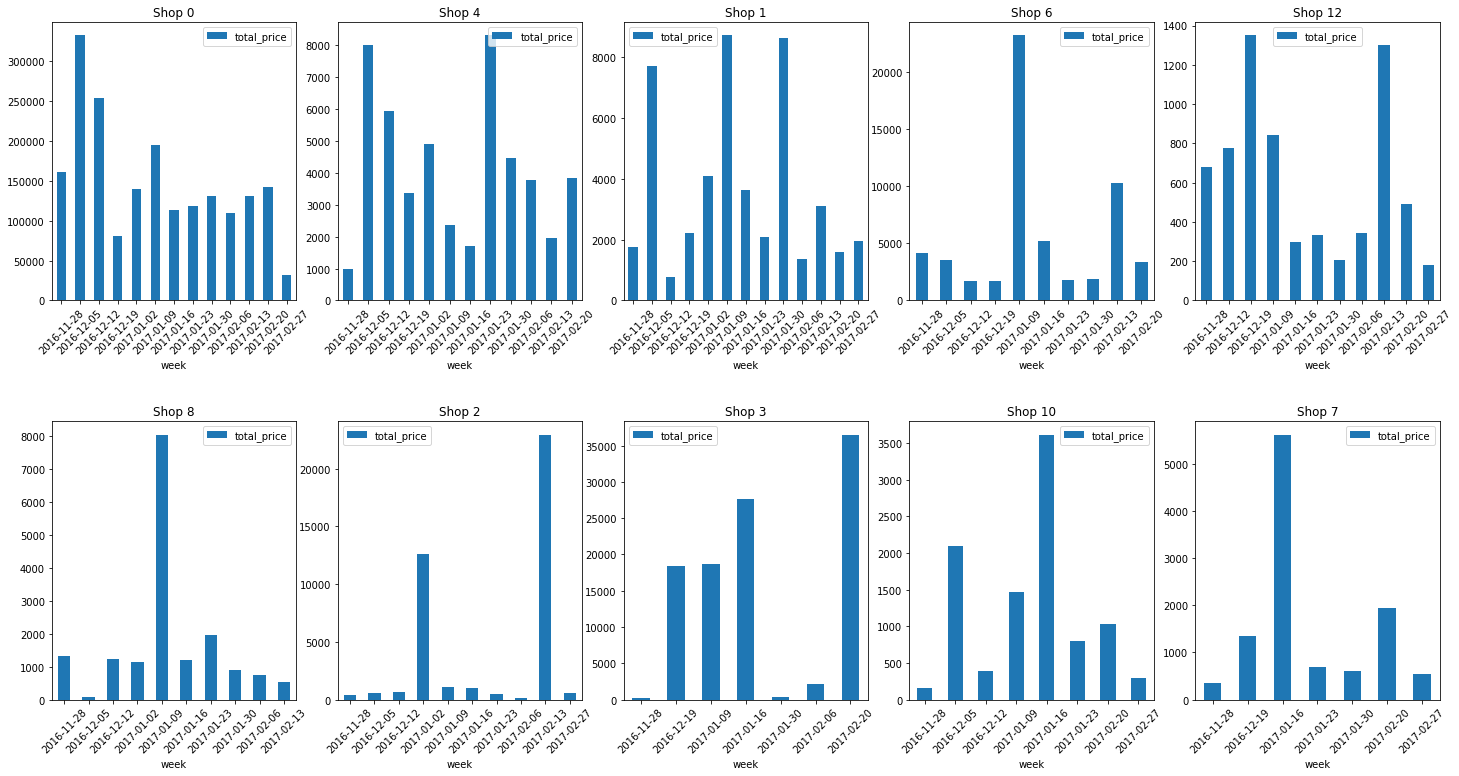

In [30]:
show_metric_shops('total_price', retail_with_price)


По некоторым магазинам мы видим, что у нас нет данных по выручке по некоторым неделям, следовательно продаж по этим неделям не было. По магазину 0 прослеживается тенденция выручки на спад. Наибольший обьем выручки по дням в магазинах 0, 6, 2, 3, однако в данных присутствует большая волатильность, так как по некоторым магазинам, как мы говорили выше немного данных.  Необходимо выяснить распределение данных по среднему чеку и количеству покупок, чтобы выяснить корреляцию по этим метрикам

<a id="graph_quantity"></a>
Исследуем данные по количеству купленных единиц товара по неделям по каждому магазину:

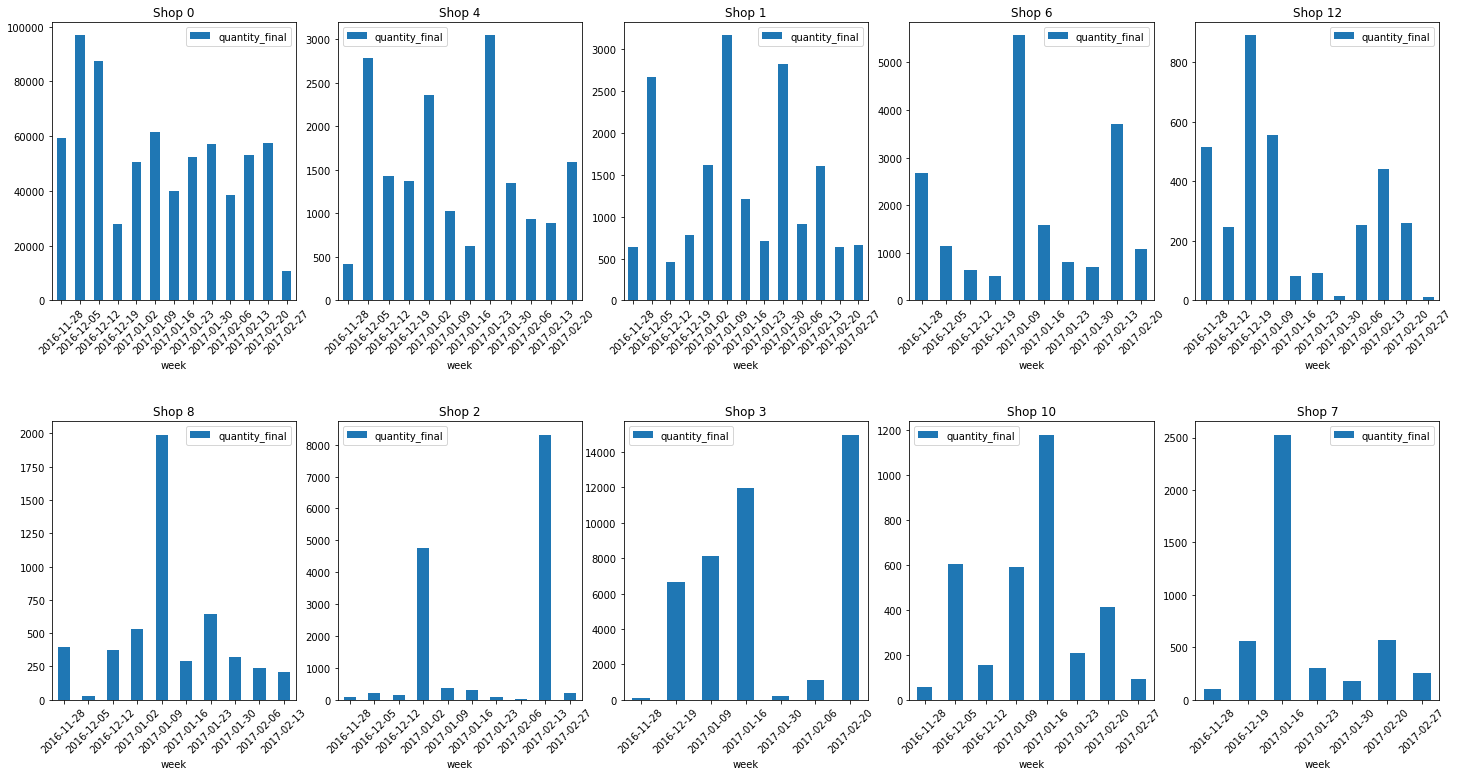

In [31]:
show_metric_shops('quantity_final', retail_with_price)

Мы заметили корреляцию в долях выручки и количества проданных единиц по магазинам в динамике по неделям. По некоторым неделям, мы видим всплески роста количества покупок, это может быть связано с маркетинговыми активностями или с предновогодним периодом.

<a id="graph_return"></a>
Исследуем данные по количеству возвратов товара по неделям по каждому магазину:

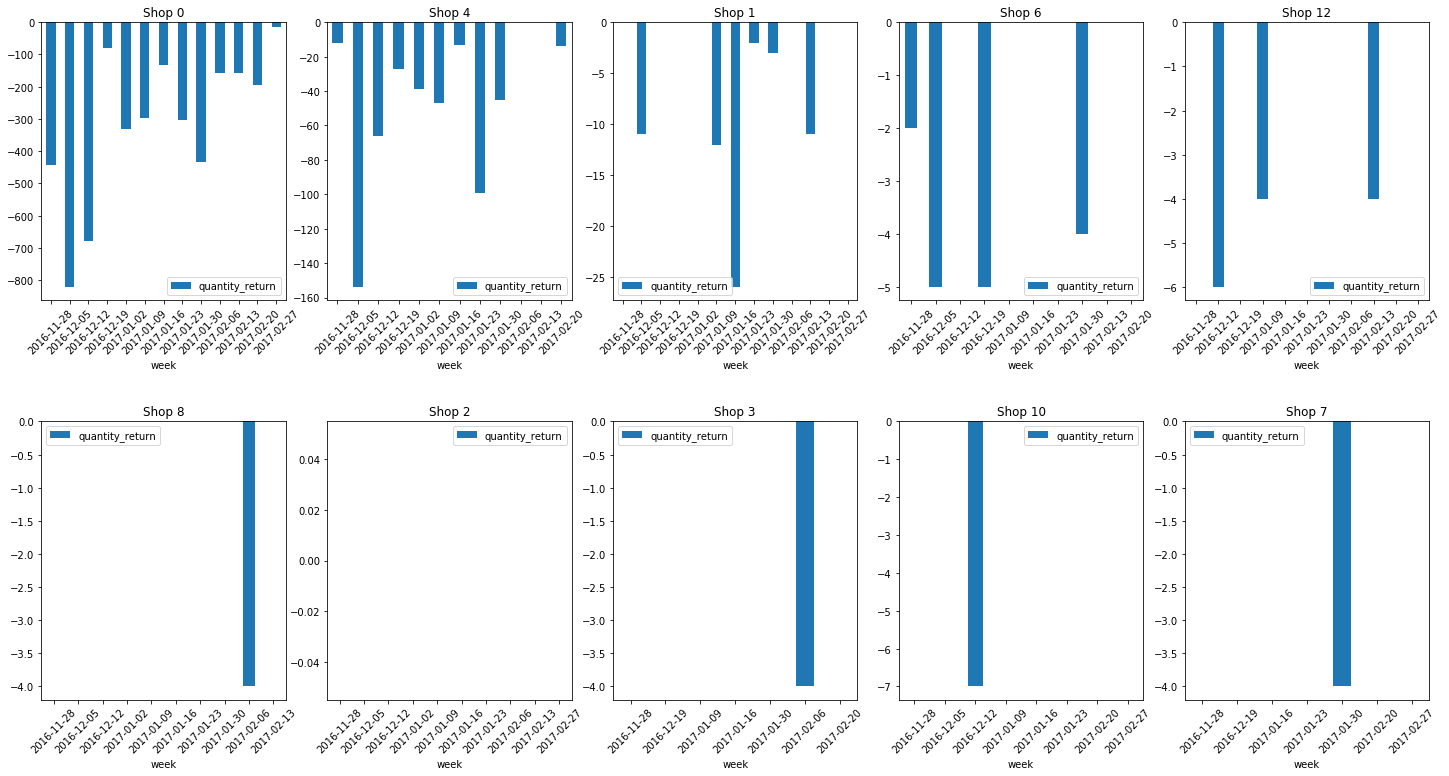

In [32]:
show_metric_shops('quantity_return', retail_with_price)

Наибольшее количество возвратов у магазинов 0 и 4, однако у магазина 0 при этом самая высокая выручка. Далее рассчитаем процент возвратов по каждому магазину

Выведем таблицу с выручкой, количеством покупок и средним чеком по неделям и магазинам:

In [33]:
shop_by_week = retail_with_price.groupby(['shop_id', 'week']).agg({'total_price':'sum', 'purchase_id':'nunique'}).reset_index()
shop_by_week['avg_check'] = shop_by_week.total_price / shop_by_week.purchase_id
shop_by_week

,shop_id,week,total_price,purchase_id,avg_check
0,Shop 0,2016-11-28,161080.965303,313,514.635672
1,Shop 0,2016-12-05,332502.776680,542,613.473758
2,Shop 0,2016-12-12,253999.468864,420,604.760640
3,Shop 0,2016-12-19,81332.437726,148,549.543498
4,Shop 0,2017-01-02,140401.684634,175,802.295341
...,...,...,...,...,...
146,Shop 8,2017-02-13,534.356833,1,534.356833
147,Shop 9,2016-11-28,456.877500,1,456.877500
148,Shop 9,2017-01-16,1130.346750,1,1130.346750
149,Shop 9,2017-01-30,487.220071,1,487.220071


<a id="graph_avg_check"></a>
Напишем функцию, которая будет выводить на графики по каждому магазину динамику изменения среднего чека по неделям:

In [34]:
def show_avg_check_by_shop(data):
    shop_number = 0
    fig, axes = plt.subplots(nrows=2, ncols=5, sharey=True, figsize=(20, 10))
    fig.tight_layout(h_pad=10.0)
    for row in range(0, 2):
        for column in range(0, 5):
            shop_name = shop_names[shop_number]
            shop_number += 1
            shop_data = data[data.shop_id == shop_name]
            shop_data.reset_index().plot(x='week', y='avg_check', ax=axes[row][column], kind='bar', title=shop_name, rot=45)


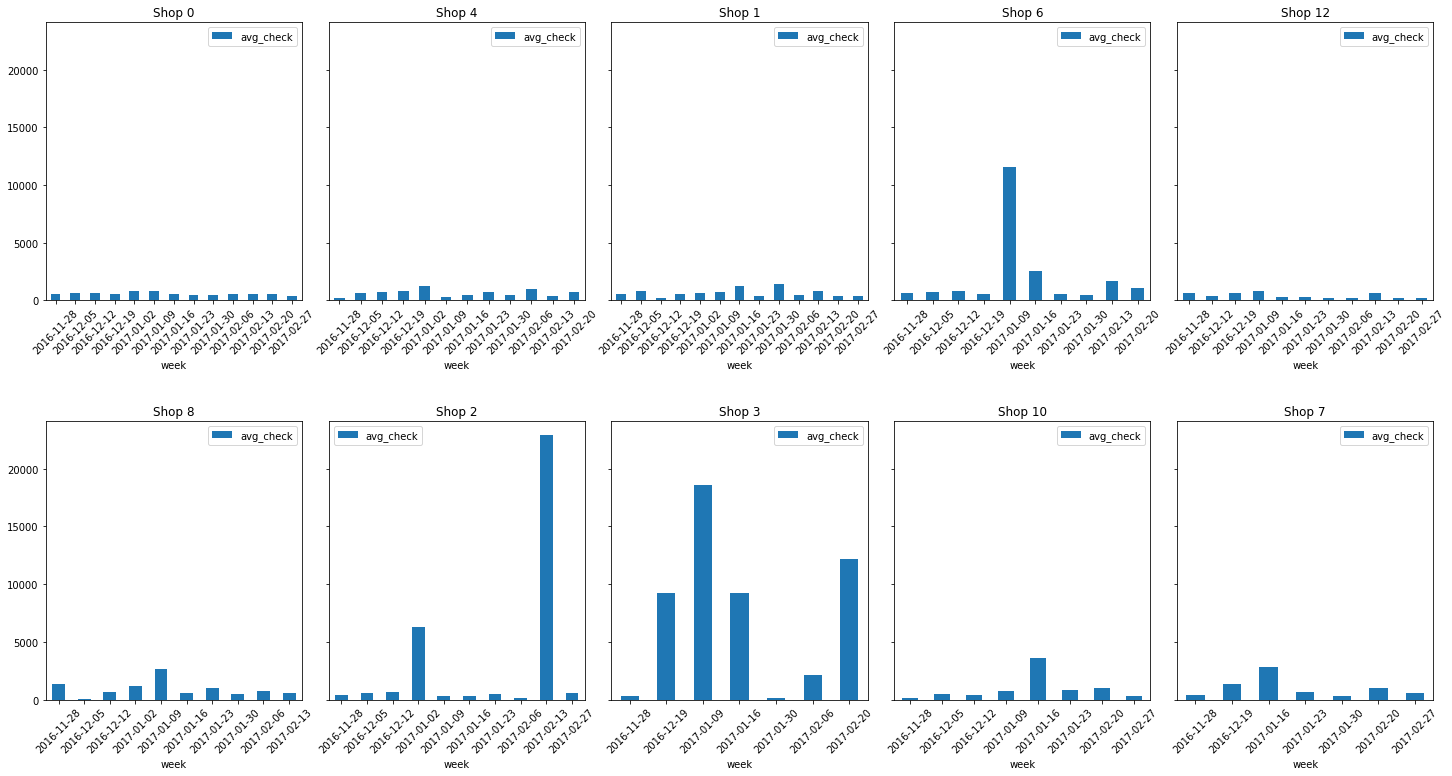

In [35]:
show_avg_check_by_shop(shop_by_week)

На графиках мы видим, что наибольший средний чек у магазина 2,3,6. По данным магазинам мы видим большую волатильность в среднем чеке в динамике

<a id="metrics_by_shop"></a>
Исследуем данные по каждому магазину по выручке, количества чеков, среднему чеку и проценту возврата:

In [36]:
shop_avg_check = retail_with_price.groupby(['shop_id']).agg({'total_price':'sum', 'purchase_id':'nunique', 'quantity_return':'sum', 'quantity':'sum'}).reset_index()
shop_avg_check['avg_check'] = shop_avg_check.total_price / shop_avg_check.purchase_id
shop_avg_check['return_rate'] = abs(shop_avg_check.quantity_return / shop_avg_check.quantity)
shop_avg_check.columns = ['shop_id', 'revenue', 'checks_count', 'quantity_return', 'quantity', 'avg_check', 'return_rate']
shop_avg_check.sort_values(by='checks_count', ascending = False).head(10)


,shop_id,revenue,checks_count,quantity_return,quantity,avg_check,return_rate
0,Shop 0,1.941543e+06,3343,-4053.0,696773,580.778610,0.005817
25,Shop 4,4.966416e+04,79,-516.0,18331,628.660293,0.028149
1,Shop 1,4.757923e+04,68,-65.0,17949,699.694572,0.003621
27,Shop 6,5.660075e+04,36,-16.0,18418,1572.243061,0.000869
4,Shop 12,6.798931e+03,16,-14.0,3374,424.933190,0.004149
29,Shop 8,1.720136e+04,16,-4.0,5019,1075.085191,0.000797
12,Shop 2,4.049858e+04,15,0.0,14500,2699.905210,0.000000
23,Shop 3,1.039804e+05,13,-4.0,43102,7998.490188,0.000093
2,Shop 10,9.862252e+03,12,-7.0,3299,821.854343,0.002122
28,Shop 7,1.111545e+04,10,-4.0,4504,1111.545406,0.000888


По данной сводной таблице по магазинам, мы можем сделать выводы, что магазины 0 и 3 имеют наибольшую выручку за весь период, магазин 3 не имеет большого количества покупок (чеков) однако имеет высокий средний чек. наибольшее количество покупок (чеков) в магазинах 0 и 4, наиболее высокий средний чек в магазинах 6,2,3. Процент возврата товаров наиболее высокий в магазине 4, но он не превышает 3%.

<a id="loyalty_program_analysis"></a>
### Шаг 4. Анализ данных по сегментам участия/не участия в программе лояльности:

Выдвинем гипотезы, что участие в программе лояльности - является фактором влияющим на увеличение среднего чека  и выручки по пользователю

In [37]:
loyalty_purchase = retail_with_price[retail_with_price.loyalty_program]
not_loyalty_purchase = retail_with_price[~retail_with_price.loyalty_program]

<a id="avg_check_distribution"></a>
Выведем на график распределение среднего чека на пользователя по программе лояльности:

Text(0.5, 0, 'средний чек')

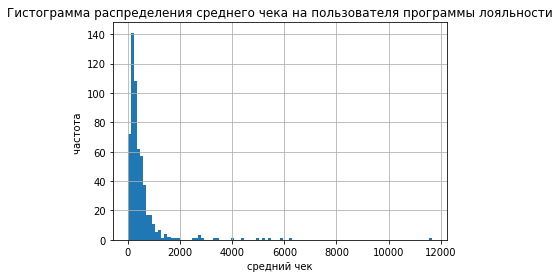

In [38]:
loyalty_avg_check = loyalty_purchase.groupby('customer_id').agg({'total_price':'sum', 'purchase_id':'nunique'}).reset_index()
loyalty_avg_check['avg_check'] = loyalty_avg_check.total_price / loyalty_avg_check.purchase_id
loyalty_avg_check.avg_check.hist(bins=100)
plt.title("Гистограмма распределения среднего чека на пользователя программы лояльности")
plt.ylabel("частота ")
plt.xlabel("средний чек")


График смещен вправо, это говорит о том, что присутствуют выбросы с высоким средним чеком. Построим диаграмму размаха и отфильтруем выбросы

Text(0, 0.5, 'количество событий')

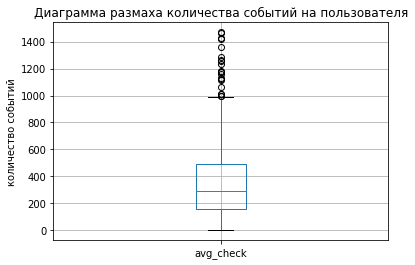

In [39]:
loyalty_avg_check[loyalty_avg_check.avg_check < 1500].boxplot('avg_check')
plt.title("Диаграмма размаха количества событий на пользователя")
plt.ylabel("количество событий")

Мы видим, что медиана по среднему чеку по пользователям программы лояльности расположена в пределах 300, 3 квартиль в пределах 500

Рассмотрим средний чек по пользователям, не участвующих в программе лояльности:

Text(0.5, 0, 'средний чек')

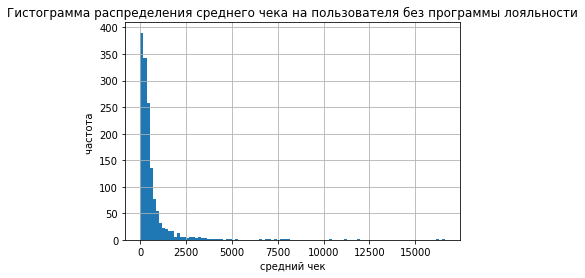

In [40]:
not_loyalty_avg_check = not_loyalty_purchase.groupby('customer_id').agg({'total_price':'sum', 'purchase_id':'nunique'}).reset_index()
not_loyalty_avg_check['avg_check'] = not_loyalty_avg_check.total_price / not_loyalty_avg_check.purchase_id
not_loyalty_avg_check.avg_check.hist(bins=100)
plt.title("Гистограмма распределения среднего чека на пользователя без программы лояльности")
plt.ylabel("частота ")
plt.xlabel("средний чек")



Text(0, 0.5, 'количество событий')

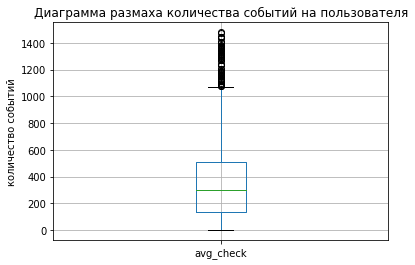

In [41]:
not_loyalty_avg_check[not_loyalty_avg_check.avg_check < 1500].boxplot('avg_check')
plt.title("Диаграмма размаха количества событий на пользователя")
plt.ylabel("количество событий")

Мы видим, что медиана средниго чека по пользователям, не участвующих в программе лояльности, совпадает с медианой по среднему чеку пользователей,участвующих в программе лояльности

<a id="retention_rate"></a>
#### Рассчитаем Retention rate

Напишем функцию расчитывающую retention rate по неделям:

In [42]:
def calculate_retention_rate(purchase, title):
    #define date when users first visit our site
    purchase.purchase_date = purchase.purchase_date.dt.round('D')
    first_purchase_date = purchase.groupby('customer_id').purchase_date.min()
    first_purchase_date.name = 'first_purchase_date'
    user_purchase = purchase.join(first_purchase_date, on='customer_id')
    #define first day of month and first day from first month of visiting it will be identificator of month and first visit month
    user_purchase['activity_week'] = pd.to_datetime(user_purchase['purchase_date'], unit='d') - pd.to_timedelta(user_purchase['purchase_date'].dt.dayofweek, unit='d')
    user_purchase['first_purchase_week'] = pd.to_datetime(user_purchase['first_purchase_date'], unit='d') - pd.to_timedelta(user_purchase['first_purchase_date'].dt.dayofweek, unit='d')
    #count lifetime value of users in cohort. Select month period using np.timedelta64(1,'M')
    user_purchase['cohort_lifetime'] = user_purchase['activity_week'] - user_purchase['first_purchase_week']
    user_purchase['cohort_lifetime'] = user_purchase['cohort_lifetime'] / np.timedelta64(1,'W')
    user_purchase['cohort_lifetime'] = user_purchase['cohort_lifetime'].round()
    cohorts = user_purchase.groupby(['first_purchase_week','cohort_lifetime']).agg({'customer_id':'nunique'}).reset_index()
    initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_purchase_week','customer_id']]
    initial_users_count = initial_users_count.rename(columns={'customer_id':'cohort_users'})
    cohorts = cohorts.merge(initial_users_count,on='first_purchase_week')
    cohorts['retention'] = cohorts['customer_id']/cohorts['cohort_users']
    retention_pivot = cohorts.pivot_table(index='first_purchase_week',columns='cohort_lifetime',values='retention',aggfunc='sum')
    #using seaborn library create a heatmap
    sns.set(style='white')
    plt.figure(figsize=(13, 9))
    plt.title(title)
    sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray')


Рассчитаем retention rate по когортам пользователей, участвующих в программе лояльности:

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


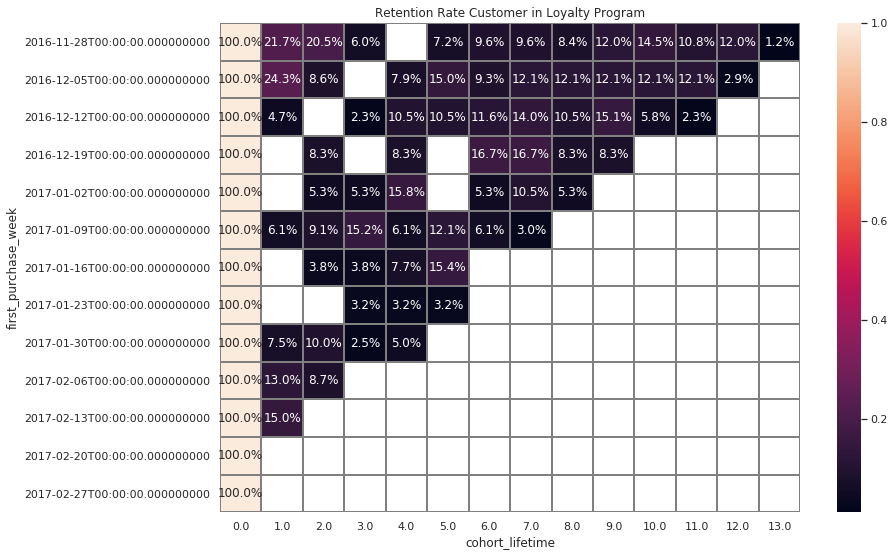

In [43]:
calculate_retention_rate(loyalty_purchase, 'Retention Rate Customer in Loyalty Program')

Рассчитаем retention rate по когортам пользователей, не участвующих в программе лояльности:

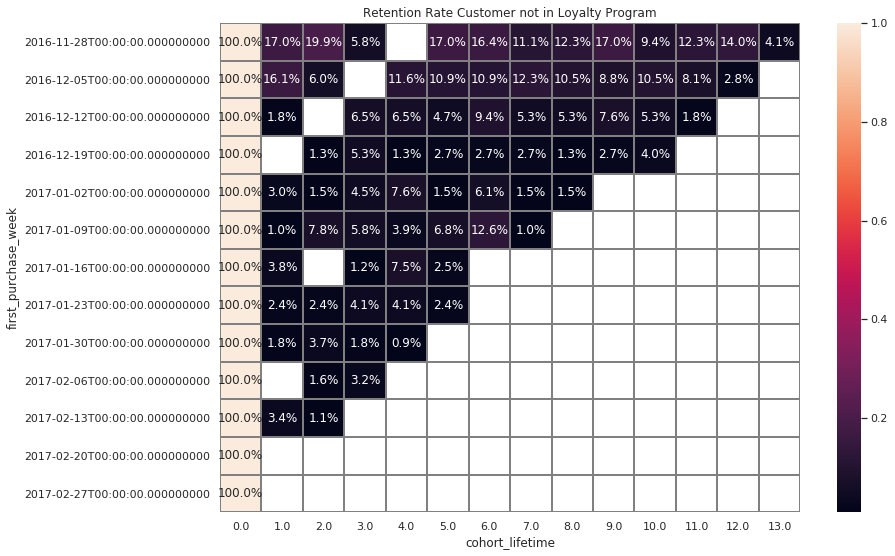

In [44]:
calculate_retention_rate(not_loyalty_purchase, 'Retention Rate Customer not in Loyalty Program')

Когорта первой недели по программе лояльности имеет более низкий retention rate по сравнению с аналогичной когортой без программы лояльности, однако последующие когорты по программе лояльности показали более высокий retention rate по сравнению с когортами пользователей,не участвующих в программе лояльности

<a id="ltv"></a>
####  Рассчитаем LTV

Напишем функцию рассчитывающую LTV по неделям:

In [45]:
def calculate_ltv(purchase, title):
    #change type
    purchase['purchase_week'] = purchase['purchase_date'].astype('datetime64[W]')
    #define month of first order
    first_purchase = purchase.groupby('customer_id').agg({'purchase_week': 'min'}).reset_index()
    first_purchase.columns = ['customer_id', 'first_purchase_week']
    #count unique users in each cohort group
    cohort_sizes = first_purchase.groupby('first_purchase_week').agg({'customer_id': 'nunique'}).reset_index()
    cohort_sizes.columns = ['first_purchase_week', 'n_buyers']
    #add first month order to orders
    purchase_new = pd.merge(purchase, first_purchase, on='customer_id')
    #count sum of revenue grouping by first_order_month and order_month
    cohorts = purchase_new.groupby(['first_purchase_week','purchase_week']).agg({'total_price': 'sum'}).reset_index()
    #ad number of users why ordered first time order on each month
    cohorts_new = pd.merge(cohort_sizes, cohorts, on='first_purchase_week')
    #we dont have info about margin, we suggested to count as 100%
    #count age of cohorts from first order month
    cohorts_new['gp'] = cohorts_new['total_price']  
    cohorts_new['age'] = (cohorts_new['purchase_week'] - cohorts_new['first_purchase_week']) / np.timedelta64(1, 'W')
    cohorts_new['age'] = cohorts_new['age'].round().astype('int')
    #count ltv
    cohorts_new['ltv'] = cohorts_new['gp'] / cohorts_new['n_buyers']
    output = cohorts_new.pivot_table(
            index='first_purchase_week', 
            columns='age', 
            values='ltv', 
            aggfunc='mean').round(2)
    #count cumulative ltv
    cummulative_ltv = output.fillna(0.0).cumsum(axis=1).round(2)
    sns.set(style='white')
    plt.figure(figsize=(13, 9))
    plt.title(title)
    sns.heatmap(cummulative_ltv, annot=True, fmt='.1f', linewidths=1, linecolor='gray')

Рассчитаем накопительный LTV по когортам пользователей, участвующих в программе лояльности:

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


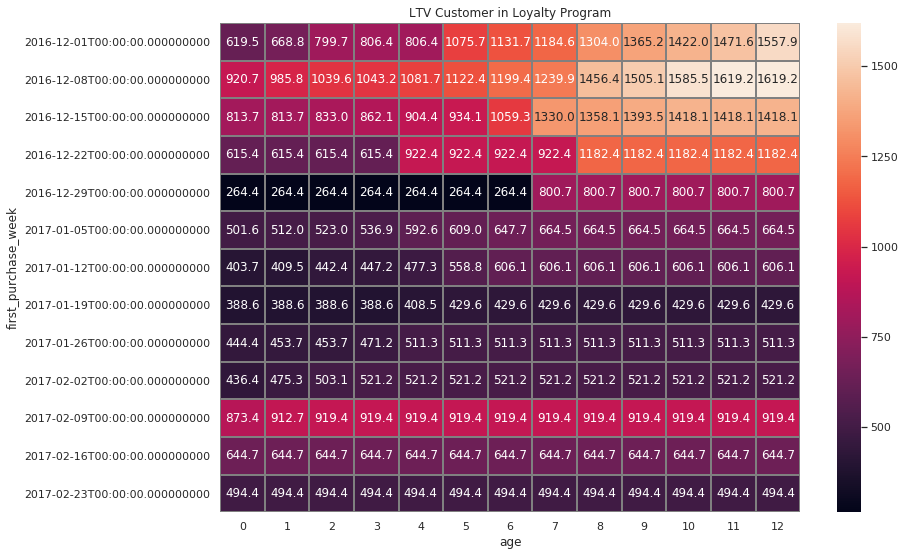

In [46]:
calculate_ltv(loyalty_purchase, 'LTV Customer in Loyalty Program')

Рассчитаем накопительный LTV по когортам пользователей, не участвующих в программе лояльности:

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


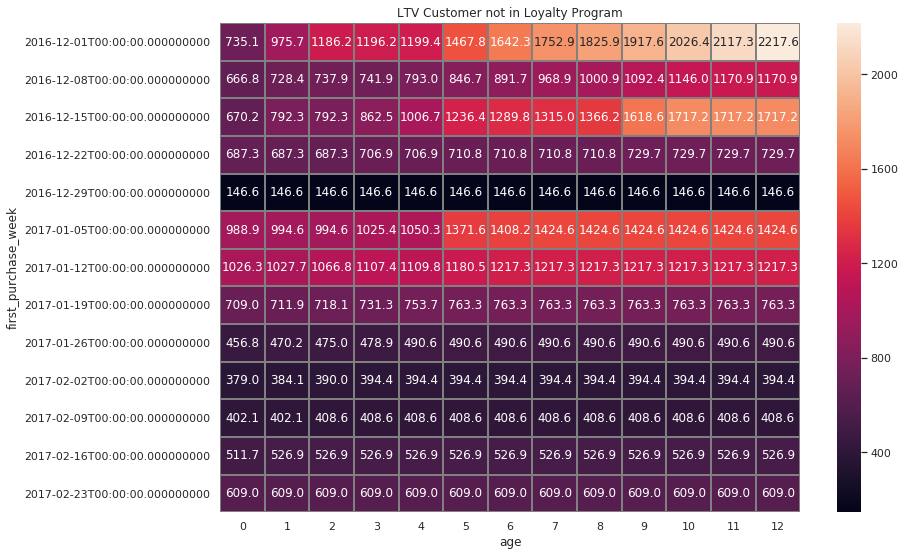

In [47]:
calculate_ltv(not_loyalty_purchase, 'LTV Customer not in Loyalty Program')

Когорты 1,3,5,6,7,8,13 недель по программе лояльности имеет более низкий накопительный LTV, чем когорты без программы лояльности

По данным LTV и Retention rate мы не можем сделать однозначного вывода о влияние программы лояльности на ключевые бизнес метрики, поэтому применим статистический тест по нашим гипотезам по двум метрикам - выручка и средний чек

<a id="avg_check_loyalty_shop"></a>
Рассчитаем средний чек по 2 группам магазинов - с программой лояльности и без:

In [48]:
shop_avg_check = retail_with_price[retail_with_price.loyalty_program].groupby(['shop_id']).agg({'total_price':'sum', 'purchase_id':'nunique', 'quantity_return':'sum', 'quantity':'sum'}).reset_index()
shop_avg_check['avg_check'] = shop_avg_check.total_price / shop_avg_check.purchase_id
shop_avg_check['return_rate'] = abs(shop_avg_check.quantity_return / shop_avg_check.quantity)
shop_avg_check.columns = ['shop_id', 'revenue', 'checks_count', 'quantity_return', 'quantity', 'avg_check', 'return_rate']
shop_avg_check.sort_values(by='checks_count', ascending = False).head(10)

,shop_id,revenue,checks_count,quantity_return,quantity,avg_check,return_rate
0,Shop 0,628846.044453,1108,-888.0,224596,567.550582,0.003954
1,Shop 19,8821.309714,2,0.0,6472,4410.654857,0.000000
3,Shop 8,239.614000,2,0.0,52,119.807000,0.000000
2,Shop 28,1466.012385,1,0.0,466,1466.012385,0.000000


In [49]:
shop_avg_check = retail_with_price[~retail_with_price.loyalty_program].groupby(['shop_id']).agg({'total_price':'sum', 'purchase_id':'nunique', 'quantity_return':'sum', 'quantity':'sum'}).reset_index()
shop_avg_check['avg_check'] = shop_avg_check.total_price / shop_avg_check.purchase_id
shop_avg_check['return_rate'] = abs(shop_avg_check.quantity_return / shop_avg_check.quantity)
shop_avg_check.columns = ['shop_id', 'revenue', 'checks_count', 'quantity_return', 'quantity', 'avg_check', 'return_rate']
shop_avg_check.sort_values(by='checks_count', ascending = False).head(10)

,shop_id,revenue,checks_count,quantity_return,quantity,avg_check,return_rate
0,Shop 0,1.312697e+06,2235,-3165.0,472177,587.336398,0.006703
24,Shop 4,4.966416e+04,79,-516.0,18331,628.660293,0.028149
1,Shop 1,4.757923e+04,68,-65.0,17949,699.694572,0.003621
26,Shop 6,5.660075e+04,36,-16.0,18418,1572.243061,0.000869
4,Shop 12,6.798931e+03,16,-14.0,3374,424.933190,0.004149
12,Shop 2,4.049858e+04,15,0.0,14500,2699.905210,0.000000
28,Shop 8,1.696175e+04,14,-4.0,4967,1211.553504,0.000805
22,Shop 3,1.039804e+05,13,-4.0,43102,7998.490188,0.000093
2,Shop 10,9.862252e+03,12,-7.0,3299,821.854343,0.002122
27,Shop 7,1.111545e+04,10,-4.0,4504,1111.545406,0.000888


<a id="check_hypotheses"></a>
### Шаг 5. Проверить гипотезы:

Перед проведением статистического теста проверим дисперсии по выборкам:

In [50]:
var_loyalty_avg_check = np.var(loyalty_avg_check.avg_check)
var_loyalty_avg_check

687260.985979322

In [51]:
var_not_loyalty_avg_check = np.var(not_loyalty_avg_check.avg_check)
var_not_loyalty_avg_check

1316635.3733591232

<a id="avg_check_stat"></a>
Нулевая гипотеза: Средний чек пользователей, участвующих в программе лояльности, не отличается от среднего чека пользователей, не участвующих в программе лояльности (они равны).

Альтернативная гипотеза H₁: Средний чек пользователей, участвующих в программе лояльности, отличается от среднего чека пользователей, не участвующих в программе лояльности (они не равны).

Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, используем t-тест: применим метод scipy.stats.ttest_ind (array1, array2, equal_var) . В качестве альфа примем общепринятое пороговое значение — 5%. Так как дисперсии не равны укажем в параметре equal_var - False.


In [52]:
alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    loyalty_avg_check.avg_check, 
    not_loyalty_avg_check.avg_check, equal_var =  False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.026060973480106973
Отвергаем нулевую гипотезу


Полученное значение p-value менее критического уровня значимости, это значит, что мы можем отвергнуть нулевую гипотезу о равенстве среднего чека пользователей в генеральных совокупностях по программе лояльности и без.

 Проверим дисперсии по выручке по двум выборкам:

In [53]:
var_loyalty_avg_check = np.var(loyalty_avg_check.total_price)
var_loyalty_avg_check

13646619.295300318

In [54]:
var_not_loyalty_avg_check = np.var(not_loyalty_avg_check.total_price)
var_not_loyalty_avg_check

15377787.60734014

<a id="avg_revenue_stat"></a>
Нулевая гипотеза: Средняя выручка пользователей, участвующих в программе лояльности, не отличается от средней выручки пользователей, не участвующих в программе лояльности (они равны).

Альтернативная гипотеза H₁: Средняя выручка пользователей, участвующих в программе лояльности, отличается от средней выручки пользователей, не участвующих в программе лояльности (они не равны).

Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, используем t-тест: применим метод scipy.stats.ttest_ind (array1, array2, equal_var) . В качестве альфа примем общепринятое пороговое значение — 5%. Так как дисперсии не равны укажем в параметре equal_var - False.


In [55]:
alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    loyalty_avg_check.total_price, 
    not_loyalty_avg_check.total_price, equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.7724643064908165
Не получилось отвергнуть нулевую гипотезу


Полученное значение p-value больше критического уровня значимости, это значит, что мы не можем отвергнуть нулевую гипотезу о равенстве средней выручки с пользователей в генеральных совокупностях по программе лояльности и без, следовательно можем предположить , что они равны


<a id="summary"></a>
### Вывод


Перед нами стояла задача - выявить ключевые метрики оценки эффективности и на их основании оценить эффективность магазинов сети.

На первом этапе мы изучили загруженные датасеты, привели названия столбцов к единому формату, проверили и исправили на корректные типы данных столбцы purchasedate, loyalty_program. В таблице retail_data мы обнаружили большое количество пропущенных значений в столбце с идентификатором покупателя(~34%), мы проверили пересечение чеков по данным покупателям без идентификаторов с покупателями с customer id и выяснили, что пересечения по ним нет. Далее мы выяснили,что наиболее частотное значение количества покупок - 1 и решили имитировать покупателей без id как  покупателей, разово купивших товар в сети наших магазинов, и присвоили им уникальные идентификаторы. Так же при анализе данных мы обнаружили отрицательные значения в столбце quantity, мы рассортировали данные по двум таблицам - с товарами, которые вернули и с товарами, которые купили, затем объединили таблицы по item_id и customer_id и рассчитали финальное количество купленного товара с учетом возврата. Далее мы добавили столбец с общей стоимостью покупки объединив таблицы с покупками с таблицей по стоимости за единицу товара по столбцу идентификатора товара.

Следующий этап состоял из анализа ключевых метрик - объем продаж (выручка и количество приобретенного товара), средний чек и количество возвратов по магазинам как за весь период, так и с разбивкой по неделям. Мы выяснили, что наибольший обьем выручки по дням в магазинах 0, 6, 2, 3, однако в данных присутсвует большая волатильность, так как по некоторым магазинам, как немного данных.  Далее мы выяснили, что наибольший средний чек у магазина 2,3,6. А наибольшее количество проданных единиц товара у магазинов 0,2 и 3. В динамике по неделям мы также наблюдали всплески роста количества покупок и среднего чека, но это может быть обусловлено маркетинговыми активностями или предновогодним периодом. Далее по сводной таблице по магазинам, мы мы пришли к выводу, что магазины 0 и 3 имеют наибольшую выручку за весь период, магазин 3 не имеет большого количества покупок (чеков) однако имеет высокий средний чек; наибольшее количество покупок (чеков) в магазинах 0 и 4, высокий средний чек в магазинах 6,2,3. Процент возврата товаров наиболее высокий в магазине 4, но он не превышает 3%.

На следующем этапе мы предположили, что программа лояльности положительно влияет на рост среднего чека и выручки по покупателям в магазинах и исследовали данные по двум сегментам пользователей - тех, кто участвовал в программе лояльности и тех, кто не участвовал. По данным сегментам мы рассчитали Retention Rate и выяснили, что процент возврата в магазин у пользователей, участвующих в программе лояльности выше, чем у пользователей без программы лояльности, что логично, так как у пользователей с программой лояльности есть бонусы и скидки в магазинах сети. Далее мы рассчитали накопленный LTV и выяснили, что по когортам 1,3,5,6,7,8,13 недель выручка по пользователям с программой лояльности ниже, чем у пользователей приобретающих товары без программы лояльности. В связи с этим мы подсчитали средний чек, сгруппировав пользователей с программой лояльности и без по магазинам, и выяснили, что средний чек в магазине 0 у пользователей программы лояльности ниже (567,5) , чем у пользователей без программы лояльности(587.3).

В заключение мы провели статистический анализ гипотез, применив метод scipy.stats.ttest_ind, и предположили, что средние чеков и выручки пользователей программы лояльности и пользовтаелей без программы лояльности равны. Результаты статистического теста опровергли гипотезу о равенстве средних чеков по двум выборкам, следовательно, на основе предыдущих данных мы можем предположить, что средний чек покупателей с программой лояльности снизился, на это могли повлиять скидки, бонусные предложения. Однако результаты статистического теста показали, что выручки по двум выборкам статистически равны, то покупатели программы лояльности чаще совершают покупки в магазинах при более низком среднем чеке, нежели покупатели без программы лояльности с более высоким средним чеком. Чтобы увеличить средний чек в магазинах с покупателями с программами лояльности, можно наладить в магазине систему дополнительных продаж - предлагать к каждой покупке сопутствующий товар.

 